In [1]:
!pip install supabase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 3.2 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.9.0
    Uninstalling typing_extensions-4.9.0:
      Successfully uninstalled typing_extensions-4.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf 23.8.0 requires cubinlinker, which is not installed.
cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cudf 23.8.0 requires ptxcompiler, which is not installed.
cuml 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
dask-cudf 23.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but

In [2]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, RobertaModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from kaggle_secrets import UserSecretsClient
from supabase import create_client, ClientOptions
import torch
from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
from statistics import mode


In [3]:
def load_model(model_path):
    model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

In [4]:
# Function to extract RoBERTa features for a batch of encodings
def extract_roberta_features_batch(encodings):
    input_ids = torch.tensor(encodings['input_ids']) 
    attention_mask = torch.tensor(encodings['attention_mask'])
    
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state[:, 0, :].detach().numpy()
    
    return last_hidden_states

# Function to extract RoBERTa features for the entire data
def extract_roberta_features(encodings, batch_size=32):
    num_samples = len(encodings.input_ids)
    num_batches = (num_samples + batch_size - 1) // batch_size
    
    features = []
    for i in tqdm(range(num_batches), desc="Extracting RoBERTa Features"):
        start_idx = i * batch_size
        end_idx = min((i + 1) * batch_size, num_samples)
        batch_encodings = {key: value[start_idx:end_idx] for key, value in encodings.items()}
        batch_features = extract_roberta_features_batch(batch_encodings)
        features.append(batch_features)
    
    features = np.concatenate(features, axis=0)
    return features


In [5]:
def fetch_data_from_supabase(schema, table, field, num_of_records):
    user_secrets = UserSecretsClient()

    # Connect to supabase
    supabase_url = "https://fglqovplibiyttjzqxuj.supabase.co"
    supabase_key = user_secrets.get_secret("SUPABASE_KEY")

    supabase = create_client(
                supabase_url,
                supabase_key,
                options=ClientOptions(
                  schema=schema
                ))


    resp = supabase.table(table).select(field).limit(num_of_records).execute()
    data = resp.data

    data = [row[field] for row in data]
    return data

In [6]:
def visualize_features(features, labels, title, dim):
    pca = PCA(n_components=dim)
    reduced_features = pca.fit_transform(features)

    # Convert labels to numerical values
    label_map = {'true': 0, 'false': 1}
    numerical_labels = [label_map[label] for label in labels]
    
    if (dim == 3):
        # Plot the reduced features in 3D
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(reduced_features[:, 0], reduced_features[:, 1], reduced_features[:, 2], c=numerical_labels, cmap='viridis', alpha=0.5)
        ax.set_title(title)
        ax.set_xlabel('Principal Component 1')
        ax.set_ylabel('Principal Component 2')
        ax.set_zlabel('Principal Component 3')
        plt.show()
    elif (dim == 2):
        # Plot the reduced features in 2d
        plt.figure(figsize=(10, 6))
        plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=numerical_labels, cmap='viridis', alpha=0.5)
        plt.title(title)
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.colorbar(label='Label')
        plt.show()


In [7]:
class WeightedKNNClassifier:
    def __init__(self, n_neighbors=5):
        self.n_neighbors = n_neighbors

    def fit(self, X_train, y_train, weights=None):
        self.X_train = X_train
        self.y_train = y_train
        self.weights = weights if weights is not None else np.ones(X_train.shape[0])

    def predict(self, X_test):
        y_pred = []
        for x in X_test:
            distances = np.sqrt(np.sum((self.X_train - x) ** 2 * self.weights, axis=1))
            nearest_indices = np.argsort(distances)[:self.n_neighbors]
            nearest_labels = self.y_train[nearest_indices].astype(int)  # Convert labels to integer type
            # Use simple majority voting for classification
            y_pred.append(np.bincount(nearest_labels).argmax())
        return np.array(y_pred)

In [8]:
def propagate_labels(labeled_texts, labeled_texts_labels, weights, unlabeled_texts):
    tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
    model = RobertaModel.from_pretrained('roberta-base')

    # Tokenize and encode the text data
    labeled_texts_encodings = tokenizer(labeled_texts, truncation=True, padding=True)
    unlabeled_texts_encodings = tokenizer(unlabeled_texts, truncation=True, padding=True)

    # Extract the features of the encodings using RoBERTa
    labeled_texts_features = extract_roberta_features(labeled_texts_encodings)
    unlabeled_texts_features = extract_roberta_features(unlabeled_texts_encodings)
    
    # Reshape the features to fill two dimensions
    labeled_texts_features_2d = train_features.reshape(labeled_texts_features.shape[0], -1)
    unlabeled_texts_features_2d = test_features.reshape(unlabeled_texts_features.shape[0], -1)

    pad_width = labeled_texts_features_2d.shape[1] - unlabeled_texts_features_2d.shape[1]
    unlabeled_texts_features_2d = np.pad(unlabeled_texts_features_2d, ((0, 0), (0, pad_width)), mode='constant')
    
    # Train KNN classifier
    knn_classifier = WeightedKNNClassifier(n_neighbors=5)
    knn_classifier.fit(labeled_texts_features_2d, labeled_texts_labels, weights=weights)

    # Make predictions on unlabeled texts
    predictions = knn_classifier.predict(unlabeled_texts_features_2d)

    return predictions
    

In [9]:
def perform_representative_replacement(features, labels):
    # Calculate distances between data points
    nn = NearestNeighbors(n_neighbors=len(features), metric='euclidean')
    nn.fit(features)
    distances, indices = nn.kneighbors(features)

    # Set a threshold for similarity
    threshold = 0.7

   # Check if labels are already numeric
    if all(isinstance(label, int) for label in labels):
        numerical_labels = labels
    else:
        label_map = {'true': 0, 'false': 1}
        numerical_labels = [label_map[label.lower()] for label in labels]

    # Group similar data points
    similar_groups = {}
    for i in range(len(features)):
        similar_group = [(i, numerical_labels[i])]
        for j, dist in zip(indices[i], distances[i]):
            if j != i and dist < threshold:
                similar_group.append((j, numerical_labels[j]))
        if len(similar_group) > 1:  
            similar_groups[i] = similar_group

    # Select representative data points and calculate weights
    representatives = []
    representatives_labels = []
    weights = []
    for group in similar_groups.values():
        group_X = [features[i] for i, j in group]
        group_Y = [j for i, j in group]  # Index train_labels with integers
        # Calculate weight based on the number of data points in the group
        weight = len(group)
        weights.append([weight for i in range(len(features[0]))])
        # Select a representative data point
        representative = np.mean(group_X, axis=0)
        representative_label = mode(group_Y)
        representatives.append(representative)
        representatives_labels.append(representative_label)


    # Replace similar data points with representatives
    summarized_features = np.array(representatives)
    summarized_labels = np.array(representatives_labels)
    summarized_weights = np.array(weights)
    
    return summarized_features, summarized_labels, summarized_weights

In [10]:
true_news = fetch_data_from_supabase("text_datasets", "true_text_dataset", "text", 10000)
false_news = fetch_data_from_supabase("text_datasets", "false_text_dataset", "text", 10000)

# Add labels and prepare data
all_texts = true_news + false_news
all_labels = ["true"] * len(true_news) + ["false"] * len(false_news)
true_news = None
false_news = None

In [11]:
print(len(all_texts))

20000


In [12]:
train_texts, test_texts, train_labels, test_labels = train_test_split(all_texts, all_labels, test_size=0.2, random_state=42)
all_texts = None
all_labels = None

In [13]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Tokenize and encode the train/test text data
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)


In [15]:
train_features = extract_roberta_features(train_encodings)
test_features = extract_roberta_features(test_encodings)

Extracting RoBERTa Features: 100%|██████████| 125/125 [19:58<00:00,  9.59s/it]


In [16]:
train_encodings = None 
test_encodings = None

(16000, 768)
(4000, 768)
(16000, 768)
(4000, 768)


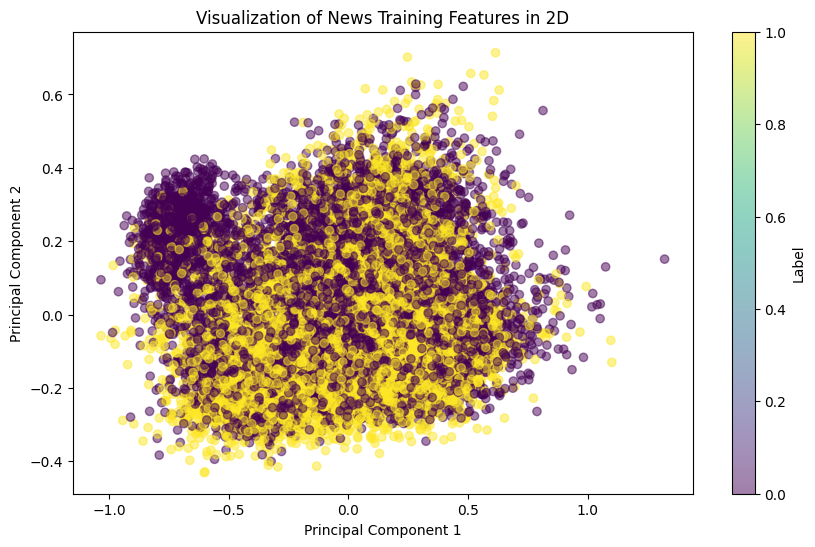

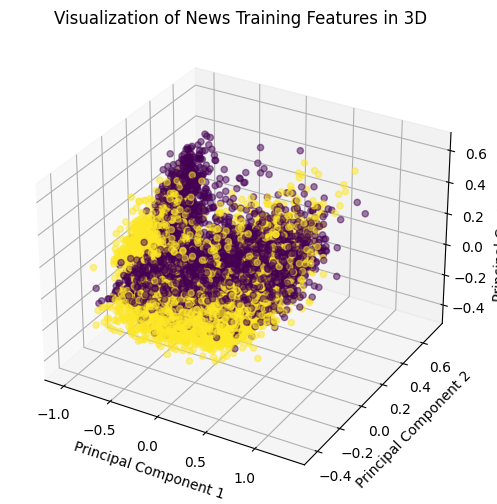

In [17]:
# Visulaize the training features
train_features_2d = train_features.reshape(train_features.shape[0], -1)
test_features_2d = test_features.reshape(test_features.shape[0], -1)

print(train_features.shape)
print(test_features.shape)

print(train_features_2d.shape)
print(test_features_2d.shape)


visualize_features(train_features_2d, train_labels, 'Visualization of News Training Features in 2D', 2)
visualize_features(train_features_2d, train_labels, 'Visualization of News Training Features in 3D', 3)


In [18]:
pad_width = train_features_2d.shape[1] - test_features_2d.shape[1]
test_features_2d = np.pad(test_features_2d, ((0, 0), (0, pad_width)), mode='constant')
print(test_features_2d.shape)


(4000, 768)


In [19]:
# Train KNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(train_features_2d, train_labels)

# Make predictions on test data
predictions = knn_classifier.predict(test_features_2d)

# Evaluate the classifier
accuracy = accuracy_score(test_labels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.83375


In [20]:
print(len(train_labels))
print(len(train_features_2d))

16000
16000


In [21]:
# Calculate distances between data points
nn = NearestNeighbors(n_neighbors=len(train_features_2d), metric='euclidean')
nn.fit(train_features_2d)
distances, indices = nn.kneighbors(train_features_2d)

# Set a threshold for similarity
threshold = 0.7

label_map = {'true': 0, 'false': 1}
numerical_train_labels = [label_map[label] for label in train_labels]

# Group similar data points
similar_groups = {}
for i in range(len(train_features_2d)):
    similar_group = [(i, numerical_train_labels[i])]
    for j, dist in zip(indices[i], distances[i]):
        if j != i and dist < threshold:
            similar_group.append((j, numerical_train_labels[j]))
    if len(similar_group) > 1:  
        similar_groups[i] = similar_group

# Select representative data points and calculate weights
representatives = []
representatives_labels = []
weights = []
for group in similar_groups.values():
    group_X = [train_features_2d[i] for i, j in group]
    group_Y = [j for i, j in group]  # Index train_labels with integers
    # Calculate weight based on the number of data points in the group
    weight = len(group)
    weights.append([weight for i in range(len(train_features_2d[0]))])
    # Select a representative data point
    representative = np.mean(group_X, axis=0)
    representative_label = mode(group_Y)
    representatives.append(representative)
    representatives_labels.append(representative_label)
    

# Replace similar data points with representatives
summarized_train_features = np.array(representatives)
summarized_train_labels = np.array(representatives_labels)
summarized_train_weights = np.array(weights)

print(summarized_train_features.shape)
print(summarized_train_labels.shape)
print(summarized_train_weights.shape)


(11588, 768)
(11588,)
(11588, 768)


In [22]:
# Train KNN classifier after summariztion
knn_classifier = WeightedKNNClassifier(n_neighbors=5)
knn_classifier.fit(summarized_train_features, summarized_train_labels, weights=summarized_train_weights)
# Make predictions on test data
predictions = knn_classifier.predict(test_features_2d)

label_map = {'true': 0, 'false': 1}
numerical_test_labels = [label_map[label] for label in test_labels]
# Evaluate the classifier
accuracy = accuracy_score(numerical_test_labels, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.76525
